Импорт библиотек

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Анализ данных

In [ ]:
dt = pd.read_html('/content/Выгрузка 9 апреля.xls')

In [ ]:
df = dt[1]
df.head()

,№ п/п,№документа,Датарегистрации,Исх. №Дата,Адресат,Автор,Краткоесодержание,Примечание
0,1,WSR/1-838/2019,09.04.2019,208-40908.04.2019,Уразов Р.Н.,Антонова С.В. (АО «Интерфакс»),Вх - О возможности использования сетевого изда...,NaN
1,2,WSR/1-837/2019,09.04.2019,05-33809.04.2019,Уразов Р.Н.,Картошкин С.А. (Министерство просвещения Росси...,Вх - Об участии в совещании по вопросу доработ...,NaN
2,3,WSR/1-835/2019,09.04.2019,И10-14/313709.04.2019,Уразов Р.Н.,Цивилев С.Е. (Администрация Кемеровской области),Вх - О командировании Саликовой К. и Глушко Д....,NaN
3,4,WSR/1-834/2019,09.04.2019,Д2/7121-ИС03.04.2019,Иванюк Л.А.,Волков Г.А. (Министерство транспорта Российско...,Вх - Об участии в Чемпионате мира по профессио...,NaN
4,5,WSR/1-833/2019,09.04.2019,15-20/06-91108.04.2019,Уразов Р.Н.,Атанов И.В. (Ставропольский государственный аг...,Вх - Об участии в церемонии открытия Вузовског...,NaN


Информация

In [ ]:
df.describe()

,№ п/п
count,4967.000000
mean,2484.000000
std,1433.993724
min,1.000000
25%,1242.500000
50%,2484.000000
75%,3725.500000
max,4967.000000


In [ ]:
df.shape

(4967, 8)

In [ ]:
df.info

<bound method DataFrame.info of       № п/п  ... Примечание
0         1  ...        NaN
1         2  ...        NaN
2         3  ...        NaN
3         4  ...        NaN
4         5  ...        NaN
...     ...  ...        ...
4962   4963  ...        NaN
4963   4964  ...        NaN
4964   4965  ...        NaN
4965   4966  ...        NaN
4966   4967  ...        NaN

[4967 rows x 8 columns]>

Предобработка данных и выделение значимых атрибутов

In [ ]:
dt[0].T[0]
dt[0].T[1].unique().tolist()
dt[0].T[2].unique().tolist()
df = dt[1]

In [ ]:
df = dt[1].drop(['№ п/п', '№документа', 'Исх. №Дата', 'Примечание'], axis=1)
df.head(2)

,Датарегистрации,Адресат,Автор,Краткоесодержание
0,09.04.2019,Уразов Р.Н.,Антонова С.В. (АО «Интерфакс»),Вх - О возможности использования сетевого изда...
1,09.04.2019,Уразов Р.Н.,Картошкин С.А. (Министерство просвещения Росси...,Вх - Об участии в совещании по вопросу доработ...


Регулярные выражение

In [ ]:
import re

In [ ]:
adres = []
c = 0
reg_fio = r'([А-Я]\.[А-Я]\.\s?[А-Я][а-я]{1,20}|[А-Я][а-я]{1,20}\s?[А-Я]\.[А-Я]\.)'
for i in df.Адресат:
  result = re.findall(reg_fio, i)[-1]
  adres.append(result.replace(' ',''))

df['Адресат(-ы)'] = adres
df.tail(2)

,Датарегистрации,Адресат,Автор,Краткоесодержание,Адресат(-ы)
4965,01.11.2017,Уразов Р.Н.,Огородова Л.М. (Министерство образования и нау...,Протокол заседания рабочей группы приоритетног...,УразовР.Н.
4966,NaN,Уразов Р.Н.,Асаул Н.А. (Министерство транспорта Российской...,Участие в Чемпионате WorldSkills Hi-Tech Екате...,УразовР.Н.


Дополнение недостающими данными

In [ ]:
df['Адресат(-ы)'].unique().shape

(81,)

In [ ]:
df.Датарегистрации = pd.to_datetime(df.Датарегистрации)
df.Датарегистрации.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


count                    4965
unique                    372
top       2017-11-29 00:00:00
freq                       42
first     2017-01-11 00:00:00
last      2019-12-03 00:00:00
Name: Датарегистрации, dtype: object

In [ ]:
df['Агентсво'] = df.Автор.apply(lambda x: x.split('(')[1].replace(')',''))

In [ ]:
df.head(2)

,Датарегистрации,Адресат,Автор,Краткоесодержание,Адресат(-ы),Агентсво
0,2019-09-04,Уразов Р.Н.,Антонова С.В. (АО «Интерфакс»),Вх - О возможности использования сетевого изда...,УразовР.Н.,АО «Интерфакс»
1,2019-09-04,Уразов Р.Н.,Картошкин С.А. (Министерство просвещения Росси...,Вх - Об участии в совещании по вопросу доработ...,УразовР.Н.,Министерство просвещения Российской Федерации


Переписать список откуда и куда, сравнивать строки

In [ ]:
agents = []
target = ['Министерств','Правительств','Федеральн','Администр']
for i in df.Агентсво:
  br = 0
  for t in target:
    if br:
      break
    if t in i:
      br = 1
      agents.append(1)
  if not(br):
    agents.append(0)

In [ ]:
df['Тип_агентсва'] = agents
df.head()

,Датарегистрации,Адресат,Автор,Краткоесодержание,Адресат(-ы),Агентсво,Тип_агентсва
0,2019-09-04,Уразов Р.Н.,Антонова С.В. (АО «Интерфакс»),Вх - О возможности использования сетевого изда...,УразовР.Н.,АО «Интерфакс»,0
1,2019-09-04,Уразов Р.Н.,Картошкин С.А. (Министерство просвещения Росси...,Вх - Об участии в совещании по вопросу доработ...,УразовР.Н.,Министерство просвещения Российской Федерации,1
2,2019-09-04,Уразов Р.Н.,Цивилев С.Е. (Администрация Кемеровской области),Вх - О командировании Саликовой К. и Глушко Д....,УразовР.Н.,Администрация Кемеровской области,1
3,2019-09-04,Иванюк Л.А.,Волков Г.А. (Министерство транспорта Российско...,Вх - Об участии в Чемпионате мира по профессио...,ИванюкЛ.А.,Министерство транспорта Российской Федерации,1
4,2019-09-04,Уразов Р.Н.,Атанов И.В. (Ставропольский государственный аг...,Вх - Об участии в церемонии открытия Вузовског...,УразовР.Н.,Ставропольский государственный аграрный универ...,0


In [ ]:
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("russian")
def stm(doc):
    tokens = []
    for token in doc.split():
      token = stemmer.stem(token)
      tokens.append(token)
    if len(tokens) > 0:
        return (" ").join(tokens)
    return None

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
X = df.Адресат
y = df.Тип_агентсва

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify = y)
X_train = X_train.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [ ]:
vectorizer = TfidfVectorizer(max_features = 10000)

In [ ]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score

In [ ]:
%%time
model_SVC = SVC(C = 1, kernel = 'linear')
model_SVC.fit(X_train, y_train)
res = model_SVC.predict(X_test)

CPU times: user 262 ms, sys: 12 ms, total: 274 ms
Wall time: 274 ms


In [ ]:
f1_svm = f1_score(y_test, res, average='macro')
f1_svm

0.592638450291603

In [ ]:
print(classification_report(y_test, res))

              precision    recall  f1-score   support

           0       0.67      0.74      0.70       596
           1       0.53      0.45      0.49       398

    accuracy                           0.62       994
   macro avg       0.60      0.59      0.59       994
weighted avg       0.61      0.62      0.61       994



Лучшая модель, внатуре :D
Набор схожих алгоритмов обучения с учителем, использующихся для задач классификации и регрессионного анализа!
А другие нет))))))))))))))))

In [182]:
top_five = df.Агентсво.value_counts()[:5]
bar_dict = {}
for i in top_five.reset_index().values:
  bar_dict[i[0]] = i[1]

Визуализация

In [ ]:
bard = pd.DataFrame(bar_dict, index=["Количество писем"])

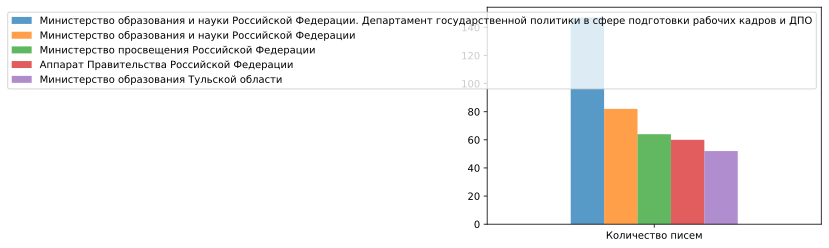

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
bard.plot(kind='bar',ax=ax, alpha=0.75, rot=0)

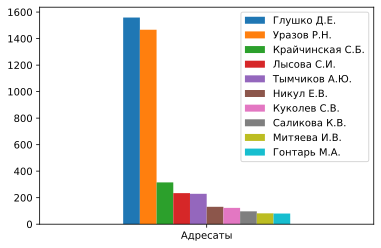

In [ ]:
ten = df.Адресат.value_counts()[:10]
dict_ten = {}
for i in ten.reset_index().values:
    dict_ten[i[0]] = i[1]
info = pd.DataFrame(dict_ten, index=["Адресаты"])
fig, ax = plt.subplots()
info.plot(kind='bar', ax=ax, rot=0)

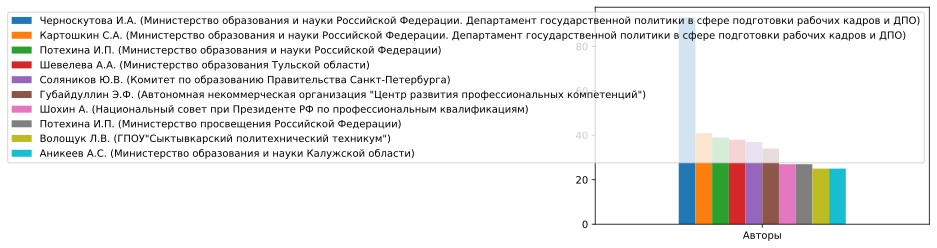

In [ ]:
ten = df.Автор.value_counts()[:10]
dict_ten = {}
for i in ten.reset_index().values:
    dict_ten[i[0]] = i[1]
info = pd.DataFrame(dict_ten, index=["Авторы"])
fig, ax = plt.subplots()
info.plot(kind='bar', ax=ax, rot=0)

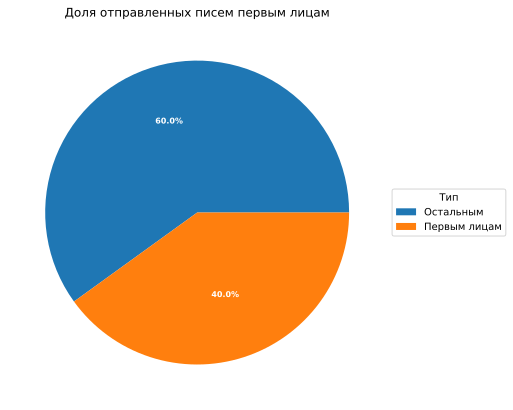

In [ ]:
fig, ax = plt.subplots(figsize=(7, 7), subplot_kw=dict(aspect="equal"))


pie_val = df.Тип_агентсва.value_counts().reset_index().values
data = [i[1] for i in pie_val]
ingredients = ['Остальным','Первым лицам']


def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n".format(pct)


wedges, texts, autotexts = ax.pie(data, autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"))
ax.legend(wedges, ingredients,
          title="Тип",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.setp(autotexts, size=8, weight="bold")
ax.set_title("Доля отправленных писем первым лицам")
plt.show()